In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats
import plotly.express as px
import plotly.graph_objects as go
import mlflow
sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')

Cargar los datasets

In [152]:
df = pd.read_csv("Training set values.csv", parse_dates = ["date_recorded"])
status_group = pd.read_csv("Training set labels.csv")
test = pd.read_csv("test.csv", parse_dates = ["date_recorded"])

In [153]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [154]:
test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


unir df (features) con status_group (target) para poder trabajar todo junto.

In [155]:
df_full = df.merge(status_group, on="id")

In [156]:
df_full.shape

(59400, 41)

In [157]:
# Guardar los IDs para luego usarlos en predicciones
train_ids = df_full["id"]
test_ids = test["id"]

# Eliminar los IDs del dataset
df_full.drop("id", axis=1, inplace=True)
test.drop("id", axis=1, inplace=True)

Pre procesado y limpieza de los datos

In [158]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   amount_tsh             59400 non-null  float64       
 1   date_recorded          59400 non-null  datetime64[ns]
 2   funder                 55763 non-null  object        
 3   gps_height             59400 non-null  int64         
 4   installer              55745 non-null  object        
 5   longitude              59400 non-null  float64       
 6   latitude               59400 non-null  float64       
 7   wpt_name               59398 non-null  object        
 8   num_private            59400 non-null  int64         
 9   basin                  59400 non-null  object        
 10  subvillage             59029 non-null  object        
 11  region                 59400 non-null  object        
 12  region_code            59400 non-null  int64         
 13  d

In [159]:
cat_cols= df_full.select_dtypes(include=['object','category']).columns
num_cols = df_full.select_dtypes(exclude=['object','category']).columns

In [160]:
df_full[cat_cols].describe()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,55763,55745,59398,59400,59029,59400,59400,59400,56066,59400,...,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,1896,2145,37399,9,19287,21,125,2092,2,1,...,8,6,5,5,10,7,3,7,6,3
top,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,9084,17402,3563,10248,508,5294,2503,307,51011,59400,...,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259


In [161]:
df_full[num_cols].describe()

,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,2012-03-29 09:11:33.818181888,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
min,0.000000,2002-10-14 00:00:00,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,2011-04-01 00:00:00,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,2012-10-10 00:00:00,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,2013-02-09 00:00:00,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2013-12-03 00:00:00,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000
std,2997.574558,NaN,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547


Tratamiento de nulos

In [162]:
summary = pd.DataFrame({
    "Missing Values": df_full.isnull().sum(),
    "Missing %": (df_full.isnull().sum() / len(df)) * 100,
    "Unique Values": df_full.nunique()
})


summary = summary[summary["Missing Values"] > 0].sort_values(by="Missing Values", ascending=False)

# Mostrar
print(summary)

                   Missing Values  Missing %  Unique Values
scheme_name                 28810  48.501684           2695
scheme_management            3878   6.528620             11
installer                    3655   6.153199           2145
funder                       3637   6.122896           1896
public_meeting               3334   5.612795              2
permit                       3056   5.144781              2
subvillage                    371   0.624579          19287
wpt_name                        2   0.003367          37399


In [163]:
df_full.nunique()

amount_tsh                  98
date_recorded              356
funder                    1896
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37399
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           11
scheme_name               2695
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity

Eliminare la columna recorded by porque tiene un solo valor

In [164]:
df_full.drop("recorded_by", axis=1, inplace=True)

tratamiento de scheme_name y scheme_management:
scheme_management
Descripción: Quién opera el punto de agua
Tiene 12 categorías y 6.5% nulos

 scheme_name
También refiere a quién lo opera
Tiene 2695 valores únicos (alta cardinalidad)
Tiene 48% nulos

Es demasiado específica genera ruido en lugar de valor, por lo cual me quedare con la columan scheme_management

In [165]:
df_full.drop("scheme_name", axis=1, inplace=True)

para llenar los nulos en scheme_management lo hare con el valor más común dentro del su grupo de management ya que es la más directamente relacionada con scheme_management. Ambas hablan de quién gestiona el punto de agua.

In [166]:
df_full["scheme_management"] = df_full["scheme_management"].astype(str)


df_full["scheme_management"] = df_full.groupby("management")["scheme_management"]\
    .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

# Lo mismo para test set 
test["scheme_management"] = test["scheme_management"].astype(str)
test["scheme_management"] = test.groupby("management")["scheme_management"]\
    .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

Rellenar nulos con "Unknown" para "funder" e "installer" y por moda para "subvillage" y "wpt_name"

In [167]:
df_full["funder"] = df_full["funder"].fillna("Unknown")
df_full["installer"] = df_full["installer"].fillna("Unknown")
df_full["subvillage"] = df_full["subvillage"].fillna(df_full["subvillage"].mode()[0])
df_full["wpt_name"] = df_full["wpt_name"].fillna(df_full["wpt_name"].mode()[0])

# test imputación
test["funder"] = test["funder"].fillna("Unknown")
test["installer"] = test["installer"].fillna("Unknown")
test["subvillage"] = test["subvillage"].fillna(df_full["subvillage"].mode()[0])
test["wpt_name"] = test["wpt_name"].fillna(df_full["wpt_name"].mode()[0])

Rellenar con el valor más frecuente (moda)

In [168]:
df_full["public_meeting"] = df_full["public_meeting"].fillna(df_full["public_meeting"].mode()[0])
df_full["permit"] = df_full["permit"].fillna(df_full["permit"].mode()[0])

# test
test["public_meeting"] = test["public_meeting"].fillna(df_full["public_meeting"].mode()[0])
test["permit"] = test["permit"].fillna(df_full["permit"].mode()[0])

C:\Users\jfdr1\AppData\Local\Temp\ipykernel_18856\1962696045.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_full["public_meeting"] = df_full["public_meeting"].fillna(df_full["public_meeting"].mode()[0])
C:\Users\jfdr1\AppData\Local\Temp\ipykernel_18856\1962696045.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_full["permit"] = df_full["permit"].fillna(df_full["permit"].mode()[0])
C:\Users\jfdr1\AppData\Local\Temp\ipykernel_18856\1962696045.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

Comparación entre columnas (ver si son duplicadas o agrupaciones) para elimanar columnas que me estas aportando la misma informacion

In [169]:
print("payment vs payment_type")
print(pd.crosstab(df_full["payment"], df_full["payment_type"]))

print("quantity vs quantity_group")
print(pd.crosstab(df_full["quantity"], df_full["quantity_group"]))

print("water_quality vs quality_group")
print(pd.crosstab(df_full["water_quality"], df_full["quality_group"]))

print("source vs source_class")
print(pd.crosstab(df_full["source"], df_full["source_class"]))

print("extraction_type vs extraction_type_class")
print(pd.crosstab(df_full["extraction_type"], df_full["extraction_type_class"]))

print("management vs management_group")
print(pd.crosstab(df_full["management"], df_full["management_group"]))

payment vs payment_type
payment_type           annually  monthly  never pay  on failure  other  \
payment                                                                  
never pay                     0        0      25348           0      0   
other                         0        0          0           0   1054   
pay annually               3642        0          0           0      0   
pay monthly                   0     8300          0           0      0   
pay per bucket                0        0          0           0      0   
pay when scheme fails         0        0          0        3914      0   
unknown                       0        0          0           0      0   

payment_type           per bucket  unknown  
payment                                     
never pay                       0        0  
other                           0        0  
pay annually                    0        0  
pay monthly                     0        0  
pay per bucket               8985      

Conclusion de la observado:
1. payment vs payment_type
Correlación 1 a 1 

2. quantity vs quantity_group
Casi idénticos 

3. water_quality vs quality_group
quality_group es una simplificación de water_quality 

4. source vs source_class
source_class es más general 

5. extraction_type vs extraction_type_class
extraction_type_class agrupa a todos los tipos 

6. management vs management_group
management_group agrupa perfectamente a management 



In [170]:
print("extraction_type_group vs extraction_type_class")
print(pd.crosstab(df_full["extraction_type_group"], df_full["extraction_type_class"]))

print("source_type vs source_class")
print(pd.crosstab(df_full["source_type"], df_full["source_class"]))

extraction_type_group vs extraction_type_class
extraction_type_class  gravity  handpump  motorpump  other  rope pump  \
extraction_type_group                                                   
afridev                      0      1770          0      0          0   
gravity                  26780         0          0      0          0   
india mark ii                0      2400          0      0          0   
india mark iii               0        98          0      0          0   
mono                         0         0       2865      0          0   
nira/tanira                  0      8154          0      0          0   
other                        0         0          0   6430          0   
other handpump               0       364          0      0          0   
other motorpump              0         0        122      0          0   
rope pump                    0         0          0      0        451   
submersible                  0         0          0      0          0   
swn 

extraction_type_group : Redundante entre extraction_type y extraction_type_class	
source_type	Similar a source, también más detallada que source_class

In [171]:
df_full.drop(columns=[
    "quantity_group",      # Duplicado de quantity
    "quality_group",       # Simplificación de water_quality
    "payment_type",        # Duplicado de payment
    "source",              # Más específica que source_class
    "source_type",         # Más específica que source_class
    "extraction_type",     # Más específica que extraction_type_class
    "extraction_type_group",  # Similar, más específica
    "management_group"     # Simplificación de management
], inplace=True)

In [172]:
test.drop(columns=[
    "scheme_name",
    "quantity_group",
    "quality_group",
    "payment_type",
    "source",
    "source_type",
    "extraction_type",
    "extraction_type_group",
    "management_group",
    "recorded_by"
], inplace=True)


Exploracion Visual:

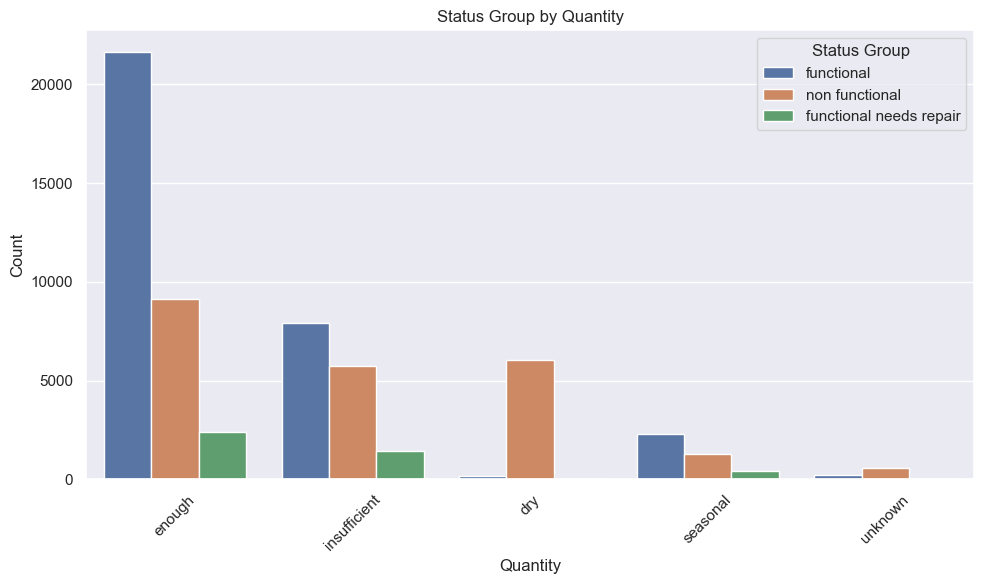

In [173]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_full,
    x="quantity",
    hue="status_group",
    order=df["quantity"].value_counts().index
)
plt.title("Status Group by Quantity")
plt.xlabel("Quantity")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Status Group")
plt.tight_layout()
plt.show()

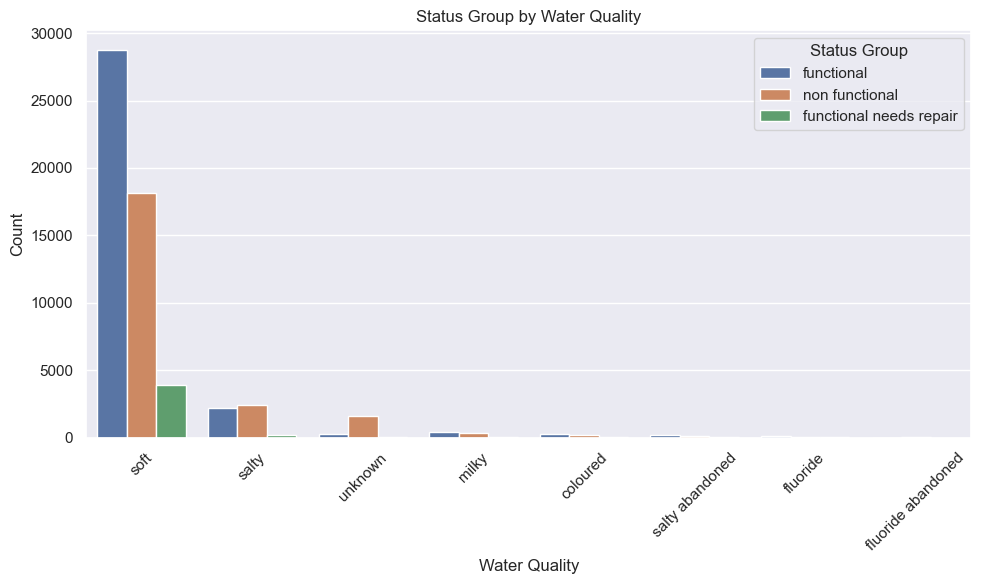

In [174]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_full,
    x="water_quality",
    hue="status_group",
    order=df_full["water_quality"].value_counts().index
)
plt.title("Status Group by Water Quality")
plt.xlabel("Water Quality")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Status Group")
plt.tight_layout()
plt.show()


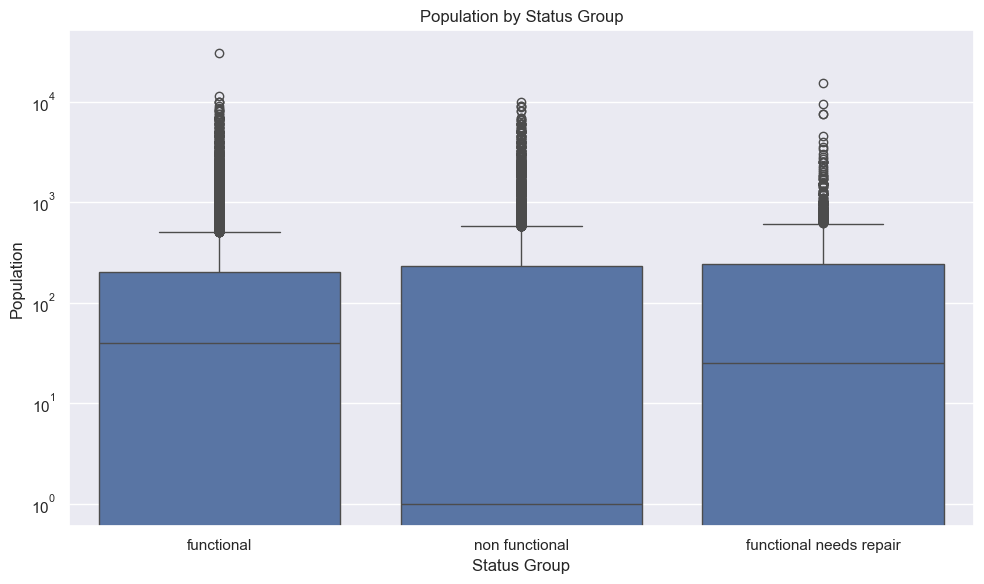

In [175]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_full,
    x="status_group",
    y="population"
)
plt.title("Population by Status Group")
plt.xlabel("Status Group")
plt.ylabel("Population")
plt.yscale("log")  # para manejar outliers
plt.tight_layout()
plt.show()

In [176]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   amount_tsh             59400 non-null  float64       
 1   date_recorded          59400 non-null  datetime64[ns]
 2   funder                 59400 non-null  object        
 3   gps_height             59400 non-null  int64         
 4   installer              59400 non-null  object        
 5   longitude              59400 non-null  float64       
 6   latitude               59400 non-null  float64       
 7   wpt_name               59400 non-null  object        
 8   num_private            59400 non-null  int64         
 9   basin                  59400 non-null  object        
 10  subvillage             59400 non-null  object        
 11  region                 59400 non-null  object        
 12  region_code            59400 non-null  int64         
 13  d

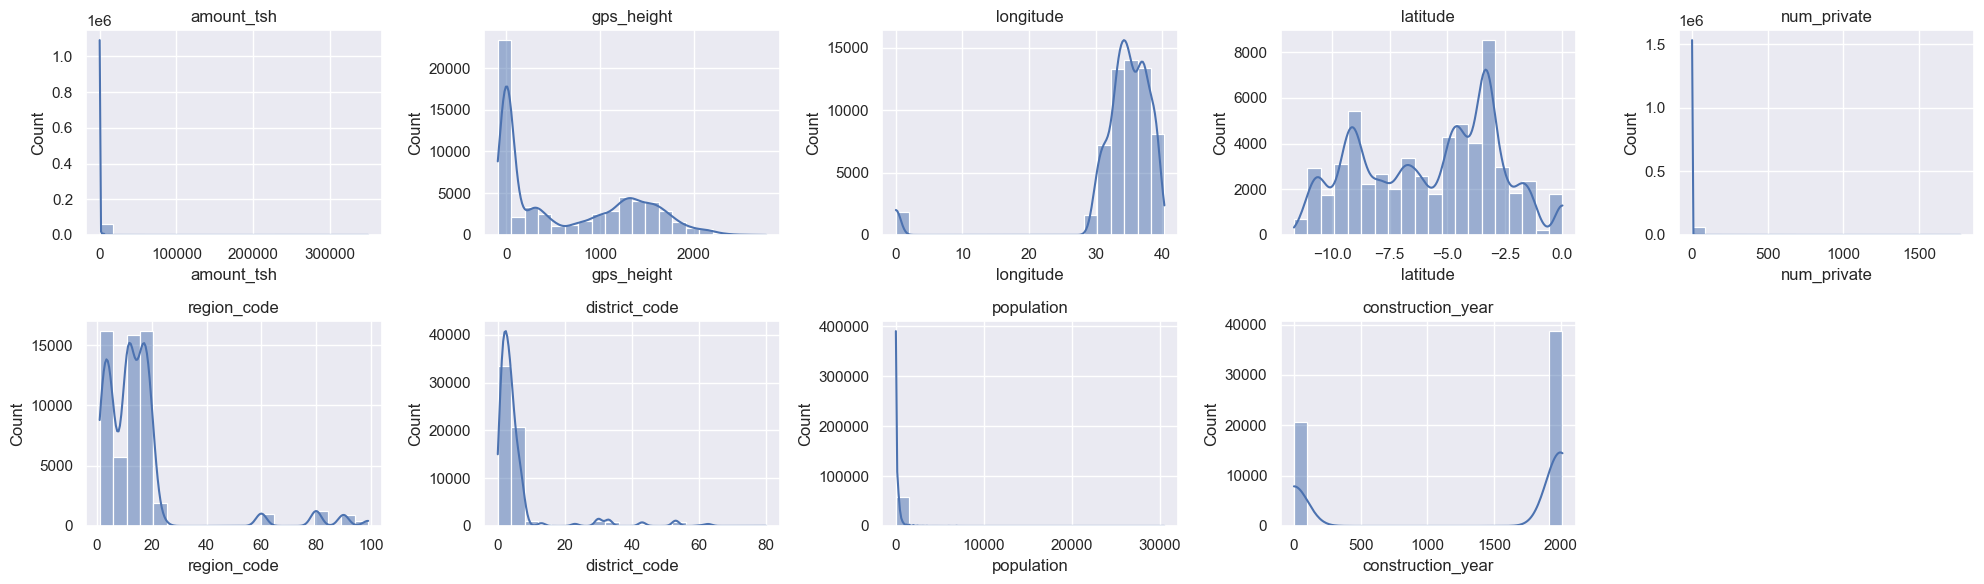

In [177]:
def plot_distributions(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    n = len(numeric_cols)
    cols = 5
    rows = n // cols + (n % cols > 0)
    
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(cols * 4, rows * 3))
    axs = axs.flatten()
    
    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col], bins=20, ax=axs[i], kde=True)
        axs[i].set_title(col)
    
    # Eliminar subplots vacíos si sobran
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

# Llamada a la función con df_full
plot_distributions(df_full)

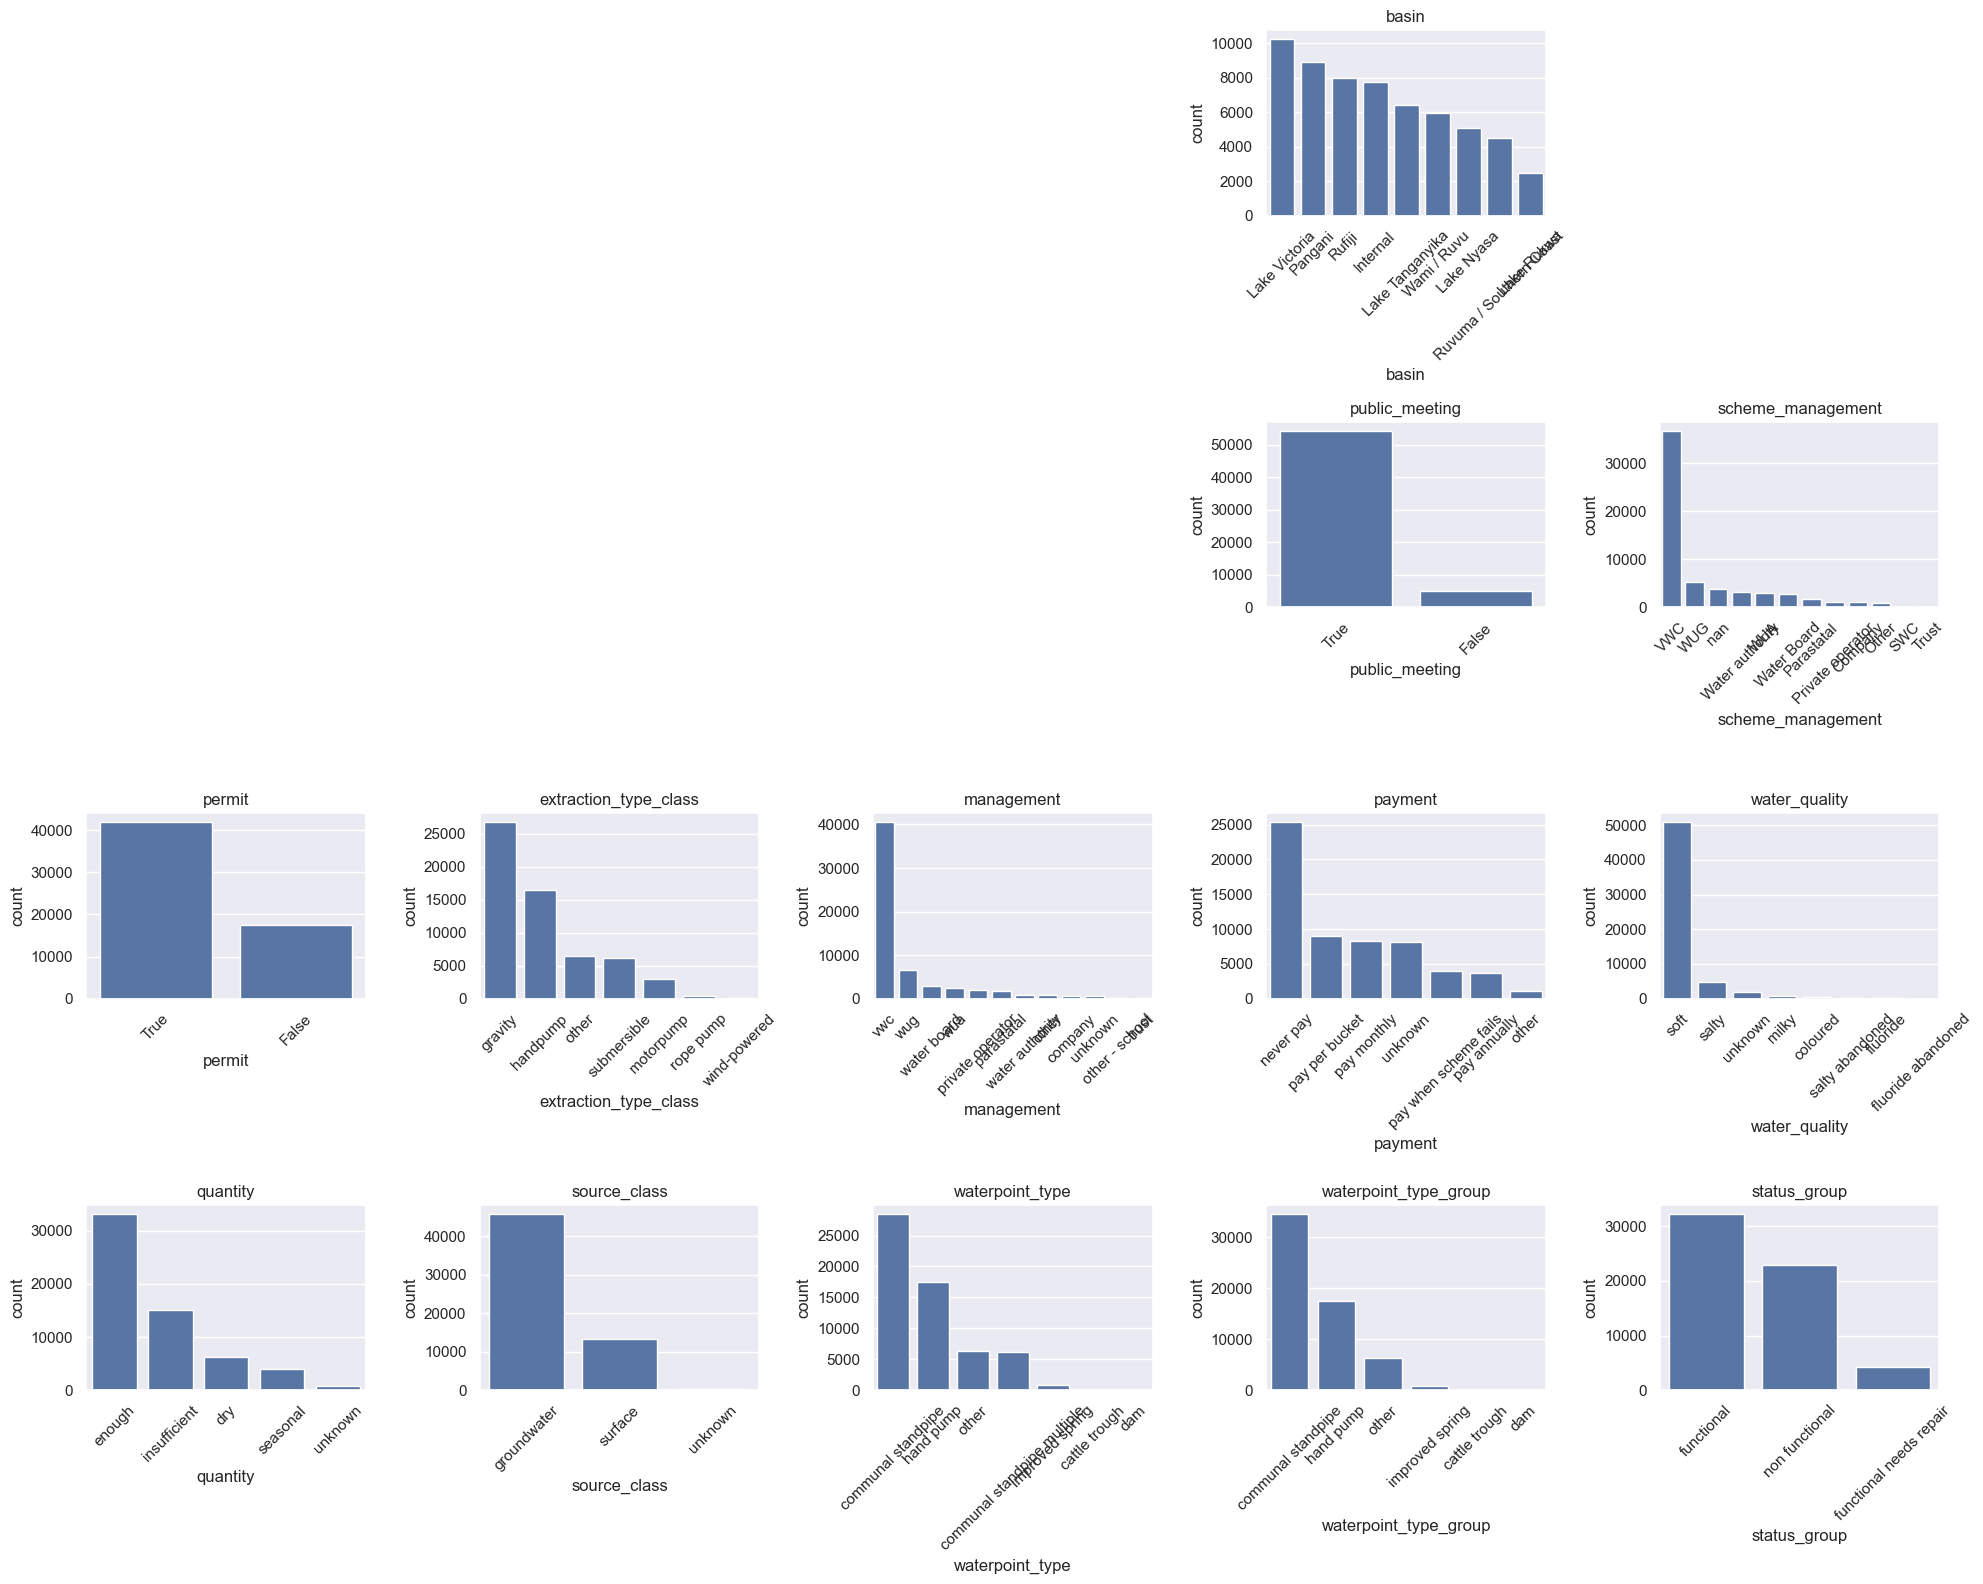

In [178]:
def plot_categoricals(df, cat_cols, max_categories=20):
    n = len(cat_cols)
    cols = 5
    rows = n // cols + (n % cols > 0)

    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(cols * 4, rows * 4))
    axs = axs.flatten()

    for i, col in enumerate(cat_cols):
        if df[col].nunique() <= max_categories:  # Evitar columnas con demasiadas categorías
            sns.countplot(data=df, x=col, ax=axs[i], order=df[col].value_counts().index)
            axs[i].set_title(col)
            axs[i].tick_params(axis='x', rotation=45)
        else:
            axs[i].set_visible(False)  # Ocultar plot si tiene demasiadas categorías

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])  # eliminar subplots vacíos

    plt.tight_layout()
    plt.show()

# Seleccionar columnas categóricas de df_full
cat_cols = df_full.select_dtypes(include=["object", "category", "bool"]).columns

# Llamar a la función
plot_categoricals(df_full, cat_cols)

In [179]:
def plot_categoricals_with_target(df, cat_cols, target_col='status_group', max_categories=20):
    n = len(cat_cols)
    cols = 4
    rows = n // cols + (n % cols > 0)

    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(cols * 5, rows * 4))
    axs = axs.flatten()

    for i, col in enumerate(cat_cols):
        if df[col].nunique() <= max_categories:
            sns.countplot(data=df, x=col, hue=target_col, ax=axs[i],
                          order=df[col].value_counts().index)
            axs[i].set_title(f"{col} vs {target_col}")
            axs[i].tick_params(axis='x', rotation=45)
        else:
            axs[i].set_visible(False)  # Ocultar plot si tiene demasiadas categorías

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

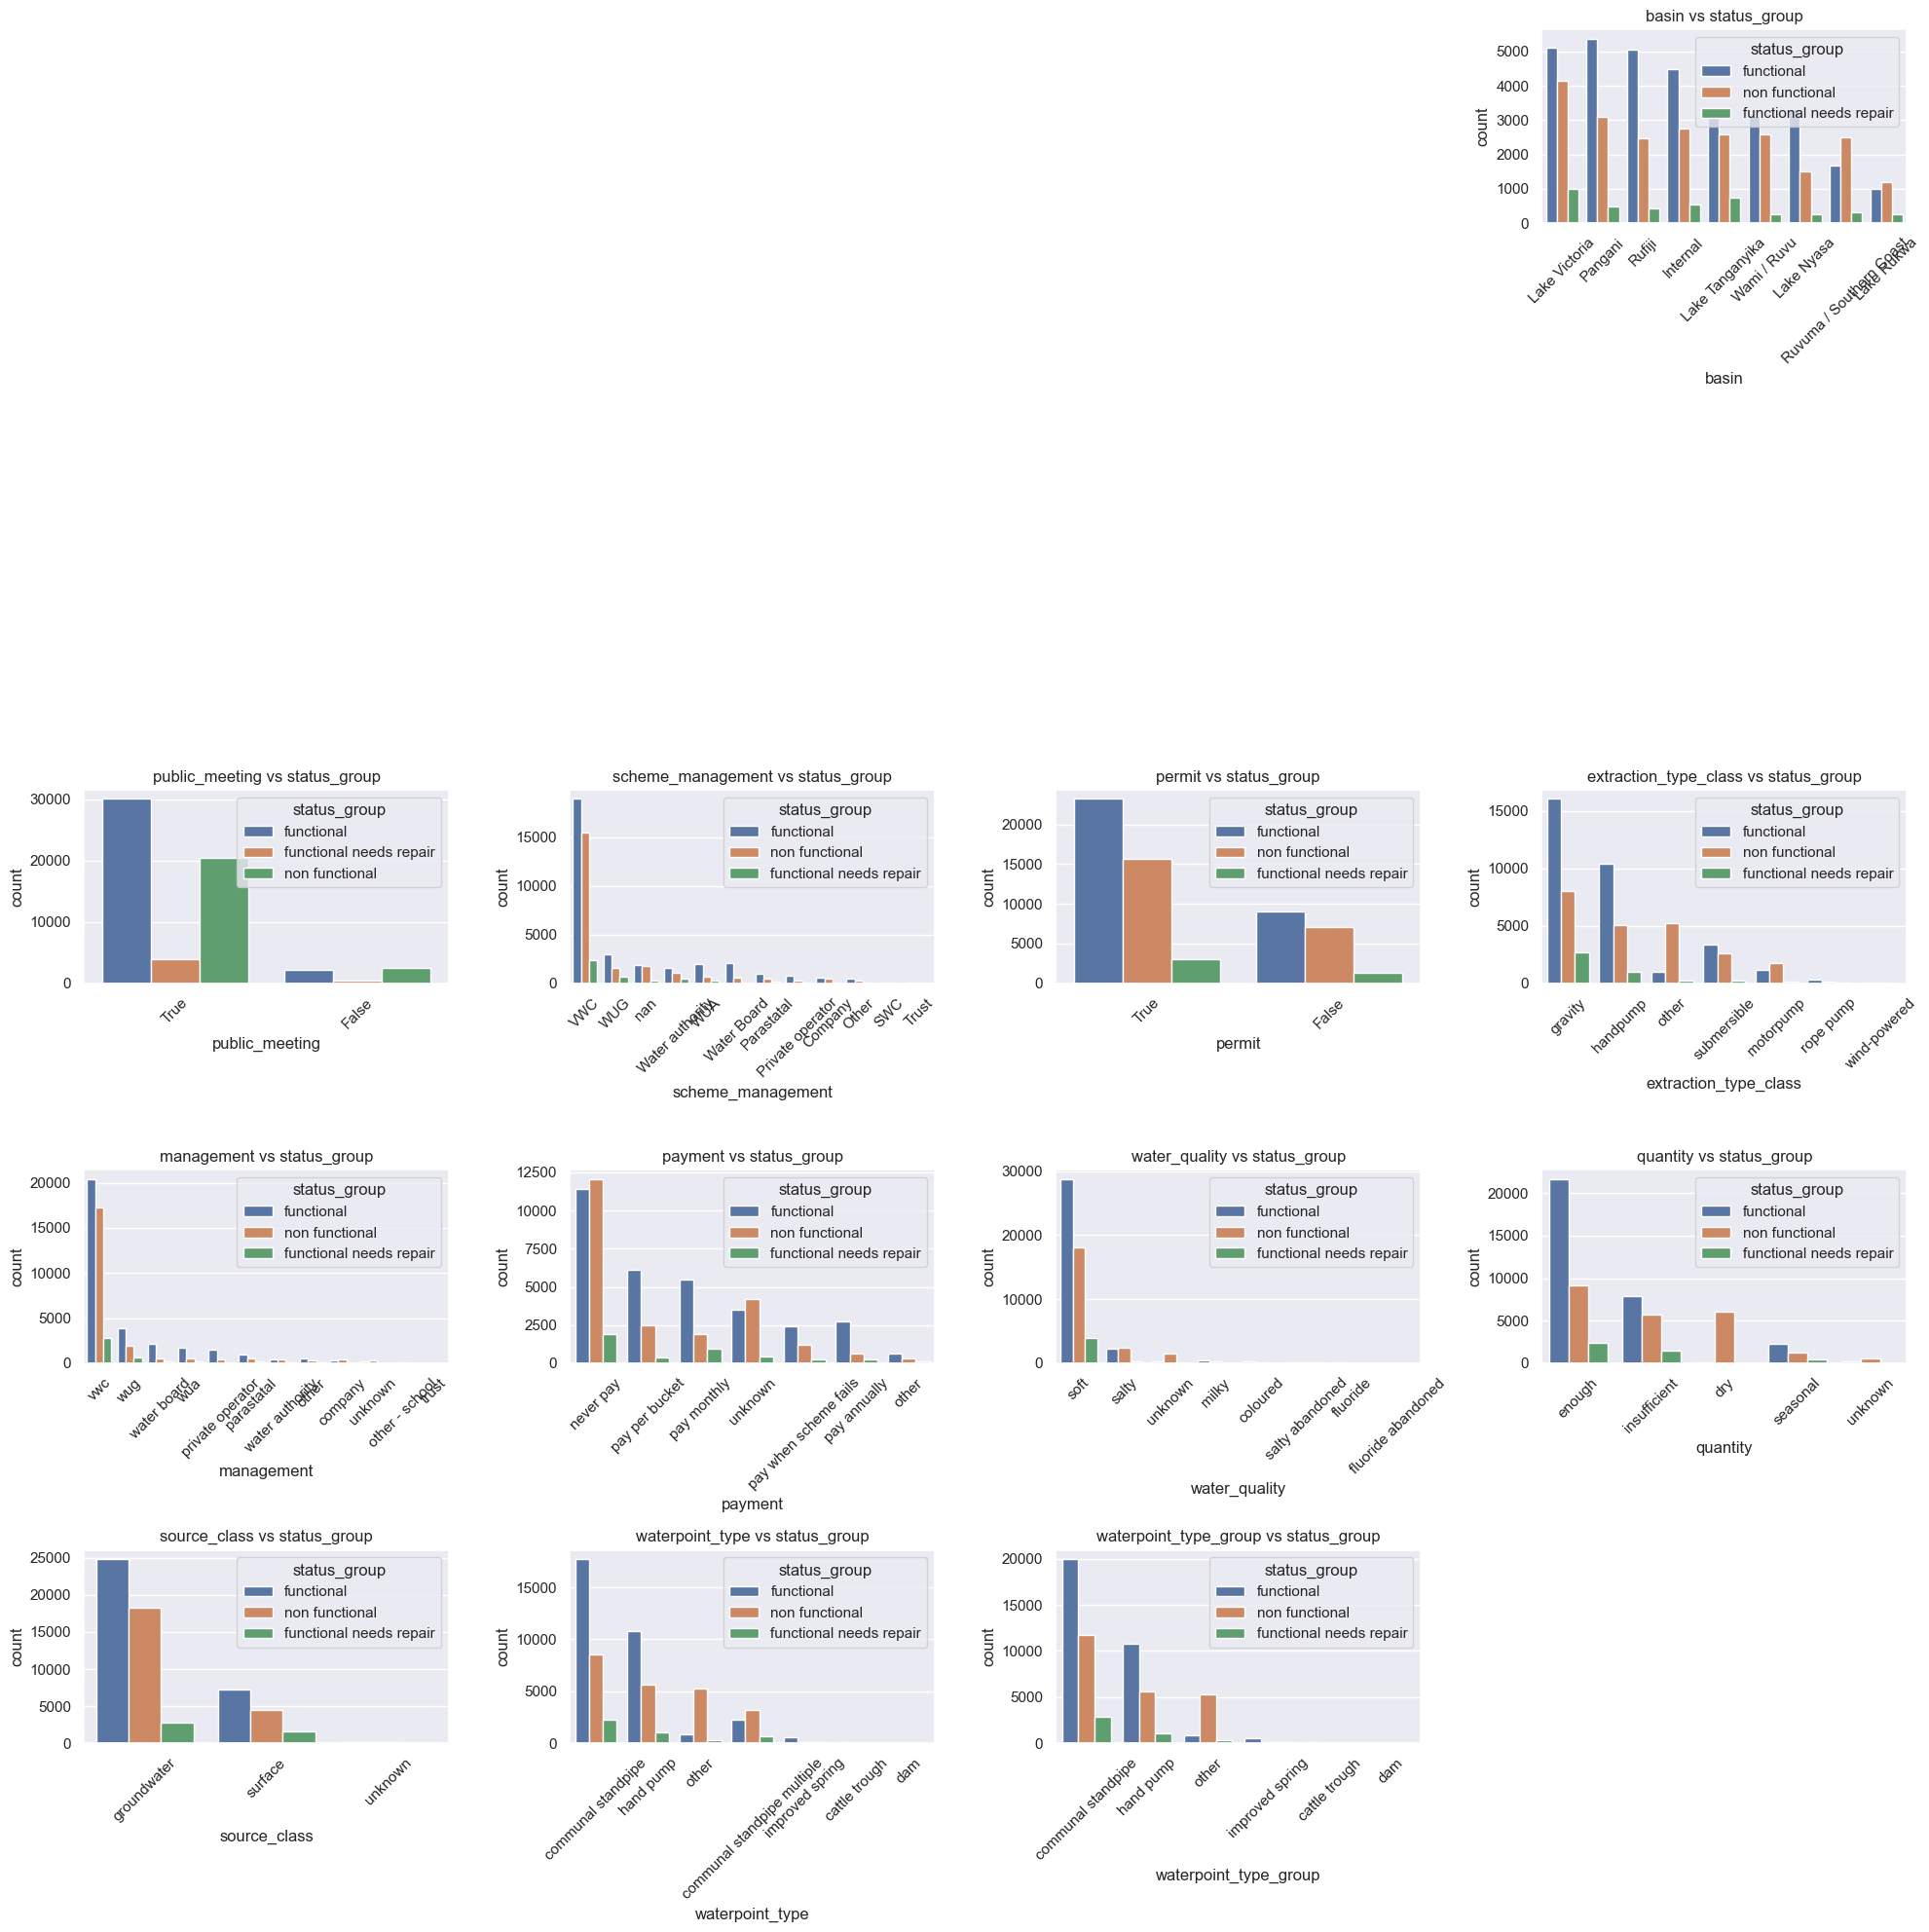

In [180]:
cat_cols = df_full.select_dtypes(include=["object", "category", "bool"]).drop(columns=["status_group"]).columns
plot_categoricals_with_target(df_full, cat_cols)

 Puntos a considerar 
Categorías tipo "unknown" o "other"
Estas aparecen en:

payment

water_quality

quantity

scheme_management

management

existesn distribuciones desequilibradas
Algunas variables tienen una categoría ultra dominante, como:

source_class = groundwater

water_quality = soft

payment = never pay


In [181]:
def plot_numericals_with_target(df, num_cols, target_col='status_group', plot_type='box'):
    n = len(num_cols)
    cols = 3
    rows = n // cols + (n % cols > 0)

    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(cols * 5, rows * 4))
    axs = axs.flatten()

    for i, col in enumerate(num_cols):
        if plot_type == 'box':
            sns.boxplot(data=df, x=target_col, y=col, ax=axs[i])
        elif plot_type == 'violin':
            sns.violinplot(data=df, x=target_col, y=col, ax=axs[i])
        axs[i].set_title(f"{col} by {target_col}")
        axs[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

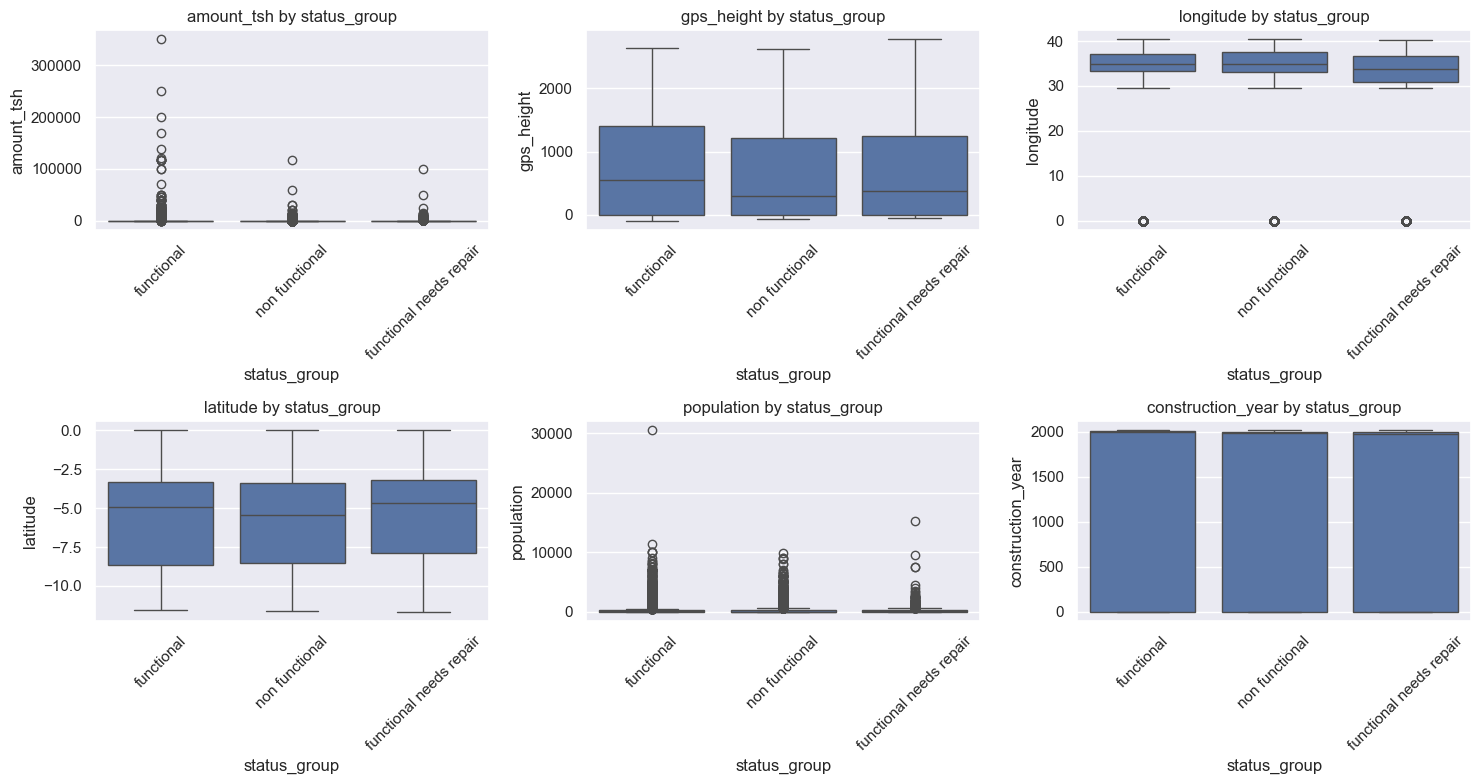

In [182]:
num_cols = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']

# Usar boxplots
plot_numericals_with_target(df_full, num_cols, plot_type='box')

 Outliers visualizados (boxplots):
amount_tsh: Muchos valores extremos (hasta >300,000), pero el 90% está cerca de 0
gps_height: Algunos valores muy altos, pero sin aparentes errores
longitude: Se observan varios valores cercanos a 0, lo cual es sospechoso (pueden ser errores GPS o pozos sin coordenadas reales)
latitude: Distribución normal para Tanzania (rango esperado entre -11 y 0)
population: Outliers marcados >10,000 — esperable en zonas urbanas, pero no todos serán errores
construction_year: Visualmente estable, pero todos los valores iguales en algunas clases (verificar si hay años = 0 o implausibles)

ahora voy a revisar las variables geográficas/ubicación para identificar:

Multicolinealidad entre variables numéricas geográficas (region_code, district_code, etc.)

Redundancia o duplicación semántica entre categóricas (region, lga, ward, etc.)

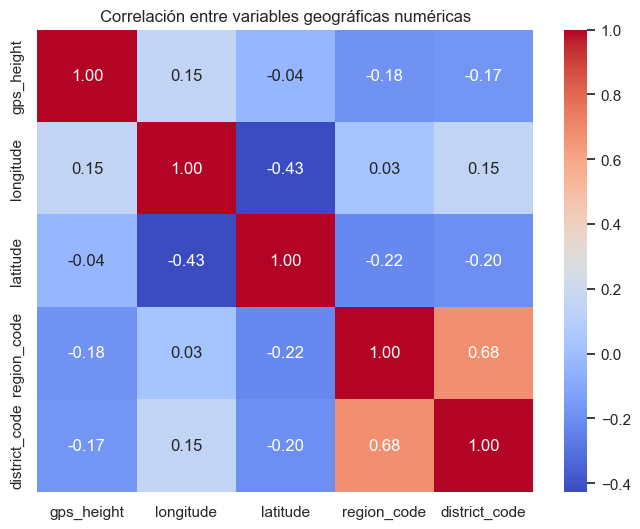

In [183]:
geo_num_cols = ['gps_height', 'longitude', 'latitude', 'region_code', 'district_code']


corr_matrix = df_full[geo_num_cols].corr()


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación entre variables geográficas numéricas")
plt.show()

aqui podemos ver que region_code y district_code tienen alta correlación. Probablemente cada distrito pertenece a una región.

Ambas son codificadas, por lo que podrían representar la misma división territorial. Antes de tomar alguna decision revisare las categoricas y ademas vere si son redundantes con region 

In [184]:
geo_cat_cols = ['region', 'region_code', 'district_code', 'lga', 'ward', 'basin', 'subvillage']
df_full[geo_cat_cols].nunique().sort_values()

basin                9
district_code       20
region              21
region_code         27
lga                125
ward              2092
subvillage       19287
dtype: int64

In [185]:
pd.crosstab(df_full["region"], df_full["region_code"])
pd.crosstab(df_full["region"], df_full["district_code"])

district_code,0,1,2,3,4,5,6,7,8,13,23,30,33,43,53,60,62,63,67,80
region,,,,,,,,,,,,,,,,,,,,
Arusha,0,189,1206,109,0,201,310,1009,0,0,0,326,0,0,0,0,0,0,0,0
Dar es Salaam,0,93,497,215,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dodoma,23,888,0,361,347,358,224,0,0,0,0,0,0,0,0,0,0,0,0,0
Iringa,0,728,530,650,2473,564,0,349,0,0,0,0,0,0,0,0,0,0,0,0
Kagera,0,771,487,402,403,0,88,260,236,0,0,669,0,0,0,0,0,0,0,0
Kigoma,0,874,1159,727,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Kilimanjaro,0,595,519,877,1225,620,109,434,0,0,0,0,0,0,0,0,0,0,0,0
Lindi,0,1,7,300,0,0,0,0,0,391,293,0,0,154,291,0,109,0,0,0
Manyara,0,550,274,297,276,186,0,0,0,0,0,0,0,0,0,0,0,0,0,0



No hay una relación 1:1, sino una relación jerárquica. Cada región contiene múltiples distritos

region y district_code no son duplicados, pero district_code es más granular (subdivisión dentro de regiones)

region_code podría ser innecesario si ya tengo region categórica y district_code codificada.

por lo tanto voy a eliminar region_code	 porque tiene alta correlación con district_code y ess redundante con region




In [186]:
df_full.drop("region_code", axis=1, inplace=True)
test.drop("region_code", axis=1, inplace=True)

seguire viendo la relacion entre las variables geograficas para eviter multicolinealidad 

In [187]:
cat_cols = df_full.select_dtypes(include=['object', 'category', 'bool']).columns
df_full[cat_cols].nunique().sort_values(ascending=False).to_frame(name='Unique Values')

,Unique Values
wpt_name,37399
subvillage,19287
installer,2145
ward,2092
funder,1896
lga,125
region,21
scheme_management,12
management,12
basin,9


Eliminare subvillag y wpt_name son muy específica, demasiados valores únicos

In [188]:
df_full.drop("subvillage", axis=1, inplace=True)
test.drop("subvillage", axis=1, inplace=True)

In [189]:
df_full.drop("wpt_name", axis=1, inplace=True)
test.drop("wpt_name", axis=1, inplace=True)

In [190]:
df_full.shape

(59400, 27)

In [191]:
test.shape

(14850, 26)

Limpieza lista!
empezare con la fase de :
Transformación variables a numéricas/ feature engineering

In [192]:
df_full_summary = pd.DataFrame({
    "Data Type": df_full.dtypes,
    "Unique Values": df_full.nunique()
}).sort_values("Unique Values", ascending=False)

df_full_summary

,Data Type,Unique Values
latitude,float64,57517
longitude,float64,57516
gps_height,int64,2428
installer,object,2145
ward,object,2092
funder,object,1896
population,int64,1049
date_recorded,datetime64[ns],356
lga,object,125
amount_tsh,float64,98


In [193]:
df_full_backup = df_full.copy()
test_backup = test.copy()

Primero las variables categoricas con baja cardinalidad. Detectare si hay categorias raras para agruparlas:
'region', 'lga', 'basin', 'scheme_management', 'management',
    'water_quality', 'payment', 'waterpoint_type',
    'extraction_type_class', 'waterpoint_type_group',
    'quantity', 'source_class'


In [194]:
cols = [
    'region', 'lga', 'basin', 'scheme_management', 'management',
    'water_quality', 'payment', 'waterpoint_type',
    'extraction_type_class', 'waterpoint_type_group',
    'quantity', 'source_class'
]

for col in cols:
    print(f" Frecuencias relativas en '{col}':\n")
    display(df_full[col].value_counts(normalize=True))

 Frecuencias relativas en 'region':



region
Iringa           0.089125
Shinyanga        0.083872
Mbeya            0.078098
Kilimanjaro      0.073721
Morogoro         0.067441
Arusha           0.056397
Kagera           0.055825
Mwanza           0.052222
Kigoma           0.047407
Ruvuma           0.044444
Pwani            0.044360
Tanga            0.042879
Dodoma           0.037054
Singida          0.035236
Mara             0.033148
Tabora           0.032980
Rukwa            0.030438
Mtwara           0.029125
Manyara          0.026650
Lindi            0.026027
Dar es Salaam    0.013552
Name: proportion, dtype: float64

 Frecuencias relativas en 'lga':



lga
Njombe          0.042138
Arusha Rural    0.021077
Moshi Rural     0.021061
Bariadi         0.019815
Rungwe          0.018620
                  ...   
Moshi Urban     0.001330
Kigoma Urban    0.001195
Arusha Urban    0.001061
Lindi Urban     0.000354
Nyamagana       0.000017
Name: proportion, Length: 125, dtype: float64

 Frecuencias relativas en 'basin':



basin
Lake Victoria              0.172525
Pangani                    0.150505
Rufiji                     0.134276
Internal                   0.131061
Lake Tanganyika            0.108283
Wami / Ruvu                0.100791
Lake Nyasa                 0.085606
Ruvuma / Southern Coast    0.075640
Lake Rukwa                 0.041313
Name: proportion, dtype: float64

 Frecuencias relativas en 'scheme_management':



scheme_management
VWC                 0.619411
WUG                 0.087643
nan                 0.065286
Water authority     0.053081
WUA                 0.048535
Water Board         0.046263
Parastatal          0.028283
Private operator    0.017896
Company             0.017862
Other               0.012896
SWC                 0.001633
Trust               0.001212
Name: proportion, dtype: float64

 Frecuencias relativas en 'management':



management
vwc                 0.681936
wug                 0.109680
water board         0.049377
wua                 0.042677
private operator    0.033182
parastatal          0.029764
water authority     0.015219
other               0.014209
company             0.011532
unknown             0.009444
other - school      0.001667
trust               0.001313
Name: proportion, dtype: float64

 Frecuencias relativas en 'water_quality':



water_quality
soft                  0.855522
salty                 0.081751
unknown               0.031582
milky                 0.013535
coloured              0.008249
salty abandoned       0.005707
fluoride              0.003367
fluoride abandoned    0.000286
Name: proportion, dtype: float64

 Frecuencias relativas en 'payment':



payment
never pay                0.426734
pay per bucket           0.151263
pay monthly              0.139731
unknown                  0.137323
pay when scheme fails    0.065892
pay annually             0.061313
other                    0.017744
Name: proportion, dtype: float64

 Frecuencias relativas en 'waterpoint_type':



waterpoint_type
communal standpipe             0.480168
hand pump                      0.294411
other                          0.107407
communal standpipe multiple    0.102744
improved spring                0.013199
cattle trough                  0.001953
dam                            0.000118
Name: proportion, dtype: float64

 Frecuencias relativas en 'extraction_type_class':



extraction_type_class
gravity         0.450842
handpump        0.277037
other           0.108249
submersible     0.104024
motorpump       0.050286
rope pump       0.007593
wind-powered    0.001970
Name: proportion, dtype: float64

 Frecuencias relativas en 'waterpoint_type_group':



waterpoint_type_group
communal standpipe    0.582912
hand pump             0.294411
other                 0.107407
improved spring       0.013199
cattle trough         0.001953
dam                   0.000118
Name: proportion, dtype: float64

 Frecuencias relativas en 'quantity':



quantity
enough          0.558687
insufficient    0.254697
dry             0.105152
seasonal        0.068182
unknown         0.013283
Name: proportion, dtype: float64

 Frecuencias relativas en 'source_class':



source_class
groundwater    0.770943
surface        0.224377
unknown        0.004680
Name: proportion, dtype: float64

In [195]:
thresholds = {
    'region': 0.01,
    'lga': 0.02,
    'basin': 0.01,
    'scheme_management': 0.01,
    'management': 0.01,
    'water_quality': 0.02,
    'payment': 0.02,
    'waterpoint_type': 0.01,
    'extraction_type_class': 0.005,
    'waterpoint_type_group': 0.005,
    'quantity': 0.01,
    'source_class': 0.01
}

for col, threshold in thresholds.items():
    freqs = df_full[col].value_counts(normalize=True)
    frequent_cat = freqs[freqs > threshold].index
    df_full[col] = np.where(df_full[col].isin(frequent_cat), df_full[col], "Rare")
    test[col] = np.where(test[col].isin(frequent_cat), test[col], "Rare")

In [196]:
cols = [
    'region', 'lga', 'basin', 'scheme_management', 'management',
    'water_quality', 'payment', 'waterpoint_type',
    'extraction_type_class', 'waterpoint_type_group',
    'quantity', 'source_class'
]

for col in cols:
    print(f" Frecuencias relativas en '{col}':\n")
    display(df_full[col].value_counts(normalize=True))

 Frecuencias relativas en 'region':



region
Iringa           0.089125
Shinyanga        0.083872
Mbeya            0.078098
Kilimanjaro      0.073721
Morogoro         0.067441
Arusha           0.056397
Kagera           0.055825
Mwanza           0.052222
Kigoma           0.047407
Ruvuma           0.044444
Pwani            0.044360
Tanga            0.042879
Dodoma           0.037054
Singida          0.035236
Mara             0.033148
Tabora           0.032980
Rukwa            0.030438
Mtwara           0.029125
Manyara          0.026650
Lindi            0.026027
Dar es Salaam    0.013552
Name: proportion, dtype: float64

 Frecuencias relativas en 'lga':



lga
Rare            0.915724
Njombe          0.042138
Arusha Rural    0.021077
Moshi Rural     0.021061
Name: proportion, dtype: float64

 Frecuencias relativas en 'basin':



basin
Lake Victoria              0.172525
Pangani                    0.150505
Rufiji                     0.134276
Internal                   0.131061
Lake Tanganyika            0.108283
Wami / Ruvu                0.100791
Lake Nyasa                 0.085606
Ruvuma / Southern Coast    0.075640
Lake Rukwa                 0.041313
Name: proportion, dtype: float64

 Frecuencias relativas en 'scheme_management':



scheme_management
VWC                 0.619411
WUG                 0.087643
nan                 0.065286
Water authority     0.053081
WUA                 0.048535
Water Board         0.046263
Parastatal          0.028283
Private operator    0.017896
Company             0.017862
Other               0.012896
Rare                0.002845
Name: proportion, dtype: float64

 Frecuencias relativas en 'management':



management
vwc                 0.681936
wug                 0.109680
water board         0.049377
wua                 0.042677
private operator    0.033182
parastatal          0.029764
water authority     0.015219
other               0.014209
Rare                0.012424
company             0.011532
Name: proportion, dtype: float64

 Frecuencias relativas en 'water_quality':



water_quality
soft       0.855522
salty      0.081751
unknown    0.031582
Rare       0.031145
Name: proportion, dtype: float64

 Frecuencias relativas en 'payment':



payment
never pay                0.426734
pay per bucket           0.151263
pay monthly              0.139731
unknown                  0.137323
pay when scheme fails    0.065892
pay annually             0.061313
Rare                     0.017744
Name: proportion, dtype: float64

 Frecuencias relativas en 'waterpoint_type':



waterpoint_type
communal standpipe             0.480168
hand pump                      0.294411
other                          0.107407
communal standpipe multiple    0.102744
improved spring                0.013199
Rare                           0.002071
Name: proportion, dtype: float64

 Frecuencias relativas en 'extraction_type_class':



extraction_type_class
gravity        0.450842
handpump       0.277037
other          0.108249
submersible    0.104024
motorpump      0.050286
rope pump      0.007593
Rare           0.001970
Name: proportion, dtype: float64

 Frecuencias relativas en 'waterpoint_type_group':



waterpoint_type_group
communal standpipe    0.582912
hand pump             0.294411
other                 0.107407
improved spring       0.013199
Rare                  0.002071
Name: proportion, dtype: float64

 Frecuencias relativas en 'quantity':



quantity
enough          0.558687
insufficient    0.254697
dry             0.105152
seasonal        0.068182
unknown         0.013283
Name: proportion, dtype: float64

 Frecuencias relativas en 'source_class':



source_class
groundwater    0.770943
surface        0.224377
Rare           0.004680
Name: proportion, dtype: float64

decidi usar Count encoding with pandas

In [197]:
cols_to_encode = [
    'region', 'lga', 'basin', 'scheme_management', 'management',
    'water_quality', 'payment', 'waterpoint_type',
    'extraction_type_class', 'waterpoint_type_group',
    'quantity', 'source_class'
]

for col in cols_to_encode:
    counts = df_full[col].value_counts().to_dict()
    df_full[col] = df_full[col].map(counts)
    test[col] = test[col].map(counts)

In [198]:
df_full.head(10)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,region,...,construction_year,extraction_type_class,management,payment,water_quality,quantity,source_class,waterpoint_type,waterpoint_type_group,status_group
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,0,5085,5294,...,1999,26780,40507,3642,50818,33186,45794,28522,34625,functional
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,0,10248,1969,...,2010,26780,6515,25348,50818,15129,13328,28522,34625,functional
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,0,8940,1583,...,2009,26780,40507,8985,50818,33186,13328,6103,34625,functional
3,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,0,4493,1730,...,1986,6179,40507,25348,50818,6246,45794,6103,34625,non functional
4,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,0,10248,3316,...,0,26780,844,25348,50818,4050,13328,28522,34625,functional
5,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,0,8940,2547,...,2009,6179,40507,8985,4856,33186,278,6103,34625,functional
6,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,0,7785,4982,...,0,16456,40507,25348,50818,33186,45794,17488,17488,non functional
7,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,0,6432,4982,...,0,16456,6515,8157,1850,33186,45794,17488,17488,non functional
8,0.0,2012-11-03,Wateraid,0,Water Aid,32.711100,-5.146712,0,6432,1959,...,0,16456,40507,25348,4856,4050,45794,17488,17488,non functional
9,0.0,2011-08-03,Isingiro Ho,0,Artisan,30.626991,-1.257051,0,10248,3316,...,0,16456,40507,25348,50818,33186,45794,17488,17488,functional


In [199]:
df_full_summary = pd.DataFrame({
    "Data Type": df_full.dtypes,
    "Unique Values": df_full.nunique()
}).sort_values("Unique Values", ascending=False)

df_full_summary

,Data Type,Unique Values
latitude,float64,57517
longitude,float64,57516
gps_height,int64,2428
installer,object,2145
ward,object,2092
funder,object,1896
population,int64,1049
date_recorded,datetime64[ns],356
amount_tsh,float64,98
num_private,int64,65


Ahora tratare date_recorded:
Transformación de la variable date recorded a días. Esto lo hago para transformar esa variable a numerica con el punto de referencia un dia despues a la fecha mas reciente del data frame para evitar valor negativos o 0

In [200]:
df_full["date_recorded"].max()

Timestamp('2013-12-03 00:00:00')

In [201]:
test["date_recorded"].max()

Timestamp('2013-12-03 00:00:00')

In [202]:
df_full['antiguedad'] = (datetime(2013,12,4) - df_full["date_recorded"])
test['antiguedad'] = (datetime(2013,12,4) - test["date_recorded"])

df_full["antiguedad"] = df_full.antiguedad.apply(lambda x: int(x.days))
test["antiguedad"] = test.antiguedad.apply(lambda x: int(x.days))

df_full.drop(columns = "date_recorded", inplace = True)
test.drop(columns = "date_recorded", inplace = True)

df_full.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,region,district_code,...,extraction_type_class,management,payment,water_quality,quantity,source_class,waterpoint_type,waterpoint_type_group,status_group,antiguedad
0,6000.0,Roman,1390,Roman,34.938093,-9.856322,0,5085,5294,5,...,26780,40507,3642,50818,33186,45794,28522,34625,functional,996
1,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,0,10248,1969,2,...,26780,6515,25348,50818,15129,13328,28522,34625,functional,273
2,25.0,Lottery Club,686,World vision,37.460664,-3.821329,0,8940,1583,4,...,26780,40507,8985,50818,33186,13328,6103,34625,functional,282
3,0.0,Unicef,263,UNICEF,38.486161,-11.155298,0,4493,1730,63,...,6179,40507,25348,50818,6246,45794,6103,34625,non functional,310
4,0.0,Action In A,0,Artisan,31.130847,-1.825359,0,10248,3316,1,...,26780,844,25348,50818,4050,13328,28522,34625,functional,875


Ahora tratae las 2 columnas con variables booleanas y las converitire en columnas numericas

In [203]:
df_full["permit"] = df_full["permit"].astype(int)
df_full["public_meeting"] = df_full["public_meeting"].astype(int)

test["permit"] = test["permit"].astype(int)
test["public_meeting"] = test["public_meeting"].astype(int)

Ahora tratare las columnas: "funder", "installer", "ward"

como tienen alta cardinalidad aplicare T0p n 

despues del modelado decidire si puedo elimnar alguna de estas columnas

primero decidire cual top deseo usar:

In [204]:
def cobertura_top_n(df, col, n):
    return df[col].value_counts(normalize=True).nlargest(n).sum()


columnas = ["funder", "installer", "ward"]
top_n_valores = [10, 30, 50]


cobertura_resultados = []


for col in columnas:
    for n in top_n_valores:
        cobertura = cobertura_top_n(df_full, col, n)
        cobertura_resultados.append({
            "Columna": col,
            "Top N": n,
            "Cobertura (%)": round(cobertura * 100, 2)
        })


cobertura_df = pd.DataFrame(cobertura_resultados)


print(cobertura_df)

     Columna  Top N  Cobertura (%)
0     funder     10          42.48
1     funder     30          61.60
2     funder     50          69.88
3  installer     10          49.53
4  installer     30          63.15
5  installer     50          69.76
6       ward     10           3.76
7       ward     30           8.54
8       ward     50          12.30


segun los resultado me quedare con el top 30, menos en ward que me quedare con un top 10 ya que Incluso con Top 50 no se logra  ni un 15% de cobertura 

In [205]:
def agrupar_top_n(df_train, df_test, col, top_n):
    top_cats = df_train[col].value_counts().nlargest(top_n).index
    df_train[col] = df_train[col].apply(lambda x: x if x in top_cats else "Other")
    df_test[col] = df_test[col].apply(lambda x: x if x in top_cats else "Other")


agrupar_top_n(df_full, test, "funder", 30)
agrupar_top_n(df_full, test, "installer", 30)
agrupar_top_n(df_full, test, "ward", 10)


for col in ["funder", "installer", "ward"]:
    counts = df_full[col].value_counts().to_dict()
    df_full[col] = df_full[col].map(counts)
    test[col] = test[col].map(counts)

In [206]:
df_full_summary = pd.DataFrame({
    "Data Type": df_full.dtypes,
    "Unique Values": df_full.nunique()
}).sort_values("Unique Values", ascending=False)

df_full_summary

,Data Type,Unique Values
latitude,float64,57517
longitude,float64,57516
gps_height,int64,2428
population,int64,1049
antiguedad,int64,356
amount_tsh,float64,98
num_private,int64,65
construction_year,int64,55
funder,int64,31
installer,int64,30


In [208]:
df_full_summary = pd.DataFrame({
    "Data Type": test.dtypes,
    "Unique Values": test.nunique()
}).sort_values("Unique Values", ascending=False)

df_full_summary

,Data Type,Unique Values
latitude,float64,14390
longitude,float64,14390
gps_height,int64,2157
population,int64,637
antiguedad,int64,331
amount_tsh,float64,68
construction_year,int64,55
num_private,int64,36
funder,int64,31
installer,int64,30
